In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
from salishsea_tools import nc_tools, viz_tools

from cmocean import cm
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Rectangle
from scipy.io import loadmat
import numpy as np
import xarray as xr
import netCDF4 as nc

%matplotlib notebook

In [3]:
plt.rcParams['font.size'] = 14

In [4]:
def plot_annotations(ax, m, annotations, zorder=None):
    """
    """
    
    # Plot Locations
    for annotation_label, annotation in annotations.items():
        ax.text(*annotation['text'], annotation_label, transform=ax.transAxes,
                fontsize=annotation['font']+1, rotation=annotation['rotate'], zorder=zorder)
        if annotation['marker'] is not None:
            x, y = m(*annotation['marker'])
            ax.plot(x, y, 'ko', markersize=8, markerfacecolor=annotation['color'], zorder=zorder)
        if annotation['arrow'] is not None:
            ax.arrow(*annotation['arrow'], head_width=0.01, fc='k', transform=ax.transAxes, zorder=zorder)

In [5]:
def plot_basemap(ax, w_map, lons=None, lats=None, offset=[None, None], zorder=[0, 1, 2]):
    """
    """
    
    # Define map window
    lon_0 = (w_map[1] - w_map[0]) / 2 + w_map[0]
    lat_0 = (w_map[3] - w_map[2]) / 2 + w_map[2]

    # Make projection
    m = Basemap(projection='lcc', resolution='h',
                lon_0=lon_0, lat_0=lat_0,
                llcrnrlon=w_map[0], urcrnrlon=w_map[1],
                llcrnrlat=w_map[2], urcrnrlat=w_map[3], ax=ax)
    
    # Default lon/lat intervals
    if lons is None:
        lons = np.floor([w_map[0], w_map[1] + 1])
    if lats is None:
        lats = np.floor([w_map[2], w_map[3] + 1])
    
    # Add features and labels
    m.drawcoastlines(zorder=zorder[1])
    m.fillcontinents(color='Burlywood', zorder=zorder[0])
    m.drawmeridians(np.arange(*lons), labels=[0, 0, 1, 0], color='dimgray', yoffset=offset[1], zorder=zorder[2])
    m.drawparallels(np.arange(*lats), labels=[0, 1, 0, 0], color='dimgray', xoffset=offset[0], zorder=zorder[2])
    
    return m

In [6]:
def plot_thalweg(ax, T_lon, T_lat):
    lines = np.loadtxt('/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt', delimiter=" ", unpack=False)
    lines = lines.astype(int)

    thalweg_lon = T_lon[lines[:,0],lines[:,1]]
    thalweg_lat = T_lat[lines[:,0],lines[:,1]]
    ax.plot(thalweg_lon, thalweg_lat, 'r')


In [7]:
def plot_map(ax, cst, bounds, grid, T, tplt, w_map = [-129, -121, 47, 51.2], idepth=0):
    """Plot Strait of Georgia study area on Basemap object
    """
    
    # Plot Basemap
    m = plot_basemap(ax, w_map, offset=[-30000, -15000], zorder=[0, 1, 7])
    
    # Plot Fraser River
    for bound in bounds:
        i_old = 0
        for i in np.argwhere(np.isnan(cst['ncst'][bound[0]:bound[1], 1]))[:, 0]:
            x, y = m(cst['ncst'][bound[0]:bound[1], 0][i_old:i],
                     cst['ncst'][bound[0]:bound[1], 1][i_old:i])
            ax.plot(x, y, 'k-')
            i_old = i + 1
    
    # Convert lon/lat to x, y
    x, y = m(grid['nav_lon'].values, grid['nav_lat'].values)

    #Overlay model domain
    #C = ax.contourf(x, y, T['vosaline'].isel(time_counter=23, deptht=idepth), range(21, 34), cmap=cm.haline, extend='both', zorder=.2)
    
    #dat = T['dissolved_inorganic_carbon'].isel(time_counter=0, deptht=idepth)
    dat = T_NEMO['Bathymetry']
    C = ax.contourf(x, y, dat, levels=np.arange(0, 450, 10), cmap=cm.deep, extend = 'both') # extend='both', zorder=.2)

    ax.contourf(x, y, grid['Bathymetry'], [-0.01, 0.01], colors='lightgray', zorder=3)
    ax.contour( x, y, grid['Bathymetry'], [0], colors='Black', zorder=4)

    #Colorbar
    fig.subplots_adjust(bottom=0.0)
    cax = fig.add_axes([0.15, 0.1, 0.73, 0.01])
    cbar = fig.colorbar(C, cax=cax, orientation='horizontal', label='DIC [μmol/kg]')
    cbar.set_label(label='water depth (m)', size=14)
    cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), size=14)
    cbar.set_ticks(range(0, 450, 50))

    # Box around model domain
    ax.plot(x[ :,  0], y[ :,  0], 'k-', zorder=6)
    ax.plot(x[ :, -1], y[ :, -1], 'k-', zorder=6)
    ax.plot(x[ 0,  :], y[ 0,  :], 'k-', zorder=6)
    ax.plot(x[-1,  :], y[-1,  :], 'k-', zorder=6)
    
    #ax.scatter(-123.43,49.04,s=650,c='darkorange',marker='o')
    # Define Significant Landmarks and Locations
    annotations = {
       'Pacific\nOcean'     : {'text': [0.10, 0.250], 'font': 14, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
       'British\nColumbia'  : {'text': [0.65, 0.850], 'font': 14, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
       #'Washington\nState'  : {'text': [0.70, 0.030], 'font': 14, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
       #'Strait of Georgia'  : {'text': [0.50, 0.575], 'font': 13, 'rotate': -40, 'color': 'r', 'marker': None, 'arrow': None},
       #'Juan de Fuca Strait': {'text': [0.36, 0.400], 'font': 13, 'rotate': -21, 'color': 'r', 'marker': None, 'arrow': None},
       'Fraser River'       : {'text': [0.80, 0.90], 'font': 13, 'rotate':  0, 'color': 'r', 'marker': None, 'arrow': None},
       #'Puget\nSound'       : {'text': [0.60, 0.120], 'font': 13, 'rotate':   0, 'color': 'r', 'marker': None, 'arrow': None},
       #' ' : {'text': [0.68, 0.550], 'font': 14, 'rotate':   0, 'color': 'azure', 'marker': [-123.43, 49.04], 'markersize': 600, 'arrow': None},
       #'Victoria'           : {'text': [0.25, 0.39], 'font': 12, 'rotate':   0, 'color': 'r', 'marker': [-123.37, 48.43], 'arrow': None},
       #'Seattle'            : {'text': [0.81, 0.230], 'font': 12, 'rotate':   0, 'color': 'r', 'marker': [-122.33, 47.61], 'arrow': None},
    }
    
    
    # Timestamp
    #ax.text(0.02, 0.01, '1 September 2016 0000 UTC: surface', transform=ax.transAxes)
    
    # Plot Annotations
    plot_annotations(ax, m, annotations, zorder=7)
    
    # Plot Thalweg
    #plot_thalweg(ax, x, y)
    
    fig.savefig('Fig1.png')

In [8]:
# Load NEMO grid
grid_NEMO = xr.open_dataset(
    '/home/sallen/MEOPAR/grid/bathymetry_201702.nc', mask_and_scale=False)

#T_NEMO = xr.open_dataset('/data/tjarniko/results/SAMPL/SalishSea_1ts_20141121_20141121_ptrc_T_20141121-20141121.nc')
T_NEMO = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
# Load Fraser coastline
print(T_NEMO['Bathymetry'])
PNWrivers = loadmat('/ocean/rich/more/mmapbase/bcgeo/PNWrivers.mat')

<xarray.DataArray 'Bathymetry' (y: 898, x: 398)>
[357404 values with dtype=float64]
Dimensions without coordinates: y, x
Attributes:
    units:      metres
    long_name:  sea_floor_depth


In [9]:
w = T_NEMO['Bathymetry'][:]
print(np.max(w))

<xarray.DataArray 'Bathymetry' ()>
array(428.)


In [10]:
# ptt = '/results/SalishSea/nowcast-green/01sep16/'
# tr = 'SalishSea_1d_20160901_20160901_ptrc_T.nc'
ptt = '//data/tjarniko/results/SAMPL/'
tr = 'SalishSea_1ts_20141121_20141121_ptrc_T_20141121-20141121.nc'
tracers = nc.Dataset(ptt+tr)
print(tracers)

hrly_dat = tracers.variables['nitrate']
print(hrly_dat)

surf_dat = hrly_dat[0,0,:,:]
tplt = surf_dat

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    name: SalishSea_1ts_20141121_20141121
    description: biogeochemical variables
    title: biogeochemical variables
    Conventions: CF-1.6
    timeStamp: 2019-Feb-13 20:56:35 GMT
    uuid: cccadb3e-46dd-440a-9079-e8a6a367e76e
    dimensions(sizes): axis_nbounds(2), x(398), y(898), nvertex(4), deptht(40), time_counter(4)
    variables(dimensions): float32 nav_lat(y,x), float32 nav_lon(y,x), float32 bounds_lon(y,x,nvertex), float32 bounds_lat(y,x,nvertex), float32 area(y,x), float32 deptht(deptht), float32 deptht_bounds(deptht,axis_nbounds), float32 nitrate(time_counter,deptht,y,x), float64 time_centered(time_counter), float64 time_centered_bounds(time_counter,axis_nbounds), float64 time_counter(time_counter), float64 time_counter_bounds(time_counter,axis_nbounds), float32 ammonium(time_counter,deptht,y,x), float32 silicon(time_counter,deptht,y,x), float32 diatoms(time_counter,deptht,y,x), float32 

## Look at this really professional looking domain map!

    adapted from Ben Moore-Maley
    if you don't want a thalweg, comment out plot_thalweg in the plot_map code..
    

<IPython.core.display.Javascript object>


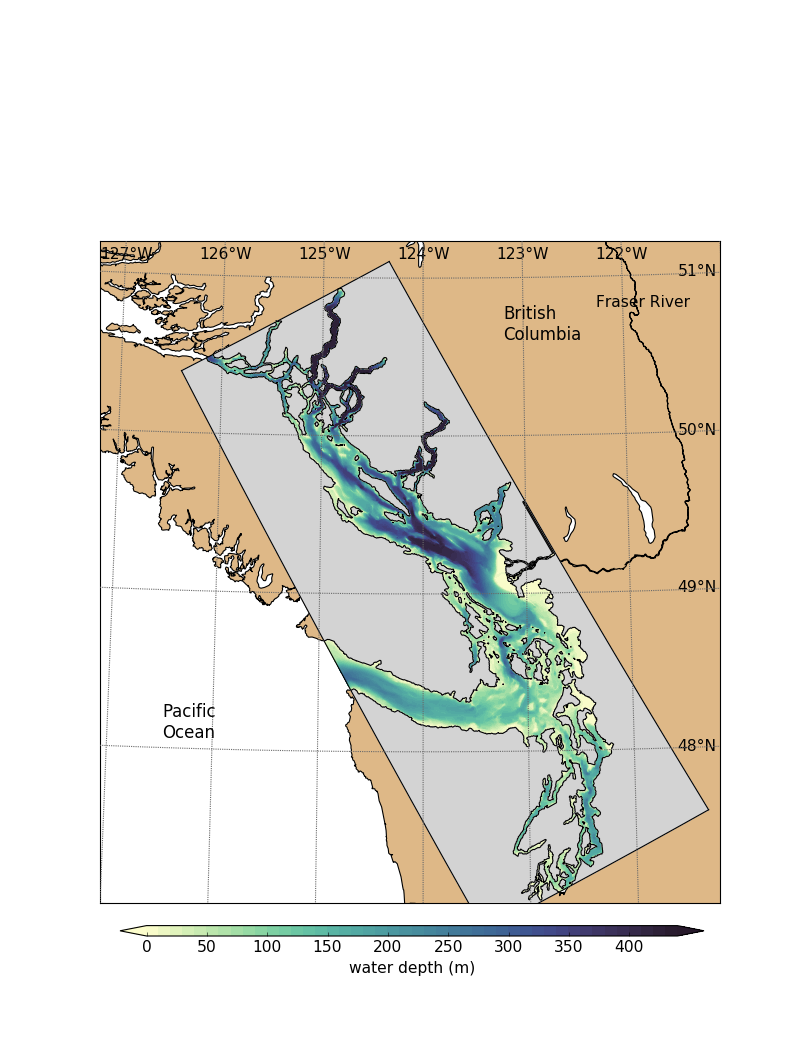

/home/tjarniko/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/tjarniko/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


In [11]:
# Define Fraser coastline regions
bounds = [[0, 26000], [61500, 77000], [107500, 114000], [200000, 203000], [326000, 327000]]

# Make figure window
fig, ax = plt.subplots(1, 1, figsize=(10, 13))

# Plot Model Domain
plot_map(ax, PNWrivers, bounds, grid_NEMO, T_NEMO, tplt, w_map = [-127, -121, 47, 51.2], idepth=0)